Deadline: Dec 10 2023

# Introduction

Under mild theoretical assumptions (non existence of arbitrage opportunities), it can be shown that the time $t$ price $P_t$ of any asset that pays $X_{t+1}$ at time $t+1$ has to satisfy the equation:
$$
    P_t = \mathbb{E}_t\left[M_{t + 1} X_{t + 1} \right]
$$
where $M_{t + 1}$ is a stochastic variable called Stochastic Discount Factor.

For the particular case of a stock, we can write it's future payoff $X_{t + 1}$as:

$$
    X_{t + 1} = D_{t + 1} + P_{t + 1}
$$,

where $D_{t + 1}$ is the dividend payed next year and $P_{t + 1}$ is the stock price next year. That is, if you buy 1 stock now and sell it exactly one year from now your cash flows are $-P_t$ today and $D_{t + 1} + P_{t + 1}$ in one year. These cashflows have to satisfy:

$$
    P_t = \mathbb{E}_t\left[M_{t + 1} (D_{t + 1} + P_{t + 1}) \right]
$$

A common assumption to study asset prices is that the Stochastic Discount Factor can be decomposed as:

$$
    M_{t + 1} = \gamma \frac{\pi_{t+1}}{\pi_t}
$$

where $\pi$ is a random variable that captures the state of the economy and $\gamma$ is a constant $\in [0, 1)$. Under this assumption, stock prices have to satisfy:

$$
    \pi_t P_t = \mathbb{E}_t\left[\gamma   \pi_{t + 1} (D_{t + 1} + P_{t + 1}) \right]
$$

Defining
$$V\equiv \pi P$$

and

$$R\equiv \gamma   \pi_{t + 1} D_{t + 1}$$
we finally get:

$$
V_t = \mathbb{E}_t\left[R + \gamma V_{t+1} \right]
$$

that is, stock prices satisfy a Bellman equation!

Use a neural network to represent the value function $V$ and solve the corresponding Bellman equation using temporal differences learning (TD).
Once you have solved for $V$, you can back out the stock price as:

$$
    P_t = \frac{V_t}{\pi_t}
$$

Plot the stock price as a function of the dividends.



# Data

You have a time series of dividends payed by a given *firm*. Suppose you also have a time series for $\pi$. The data is stored in the file replay_buffer.npy, which is a $10000 \times 4$ matrix where each row consists of an observation of:

$$
    D_t, D_{t + 1}, \pi_t, \pi_{t+1}
$$

In [ ]:
%%capture
# This snipped of code will download the data file
!wget https://www.dropbox.com/s/ms5p2hqqhlaago7/replay_buffer.npy?dl=1
!mv replay_buffer.npy?dl=1 replay_buffer.npy

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
# load the data
data = np.load('replay_buffer.npy')
data.shape

(500, 4)

In [14]:
# Neural Network Design
def build_model(input_shape):
    model = Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        # Output layer with a single neuron as we're predicting a value
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# Excluding one column which will be our target
input_shape = data.shape[1] - 1
# Build the model
model = build_model(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                256       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Prepare the Data
# D_t, D_{t+1}, \pi_t
X = data[:, :3]
# \pi_{t+1}
y = data[:, 3]

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Train model
def train_model(model, X_train, y_train, X_val, y_val, num_epochs, gamma=0.99):
    for epoch in range(num_epochs):
        for step in range(len(X_train)):
            # Current state
            current_state = X_train[step]

            # Predicted value (V_t) for the current state
            V_t_pred = model.predict(current_state.reshape(1, -1))

            # Next state
            next_state = np.roll(current_state, -1)

            # TD Target calculation using Bellman equation
            R = current_state[1]
            V_t_next_pred = model.predict(next_state.reshape(1, -1))
            TD_target = R + gamma * V_t_next_pred

            # TD Error
            TD_error = TD_target - V_t_pred

            # Update model
            with tf.GradientTape() as tape:
                V_t = model(current_state.reshape(1, -1))
                loss = tf.reduce_mean(tf.square(TD_error - V_t))
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
        # Evaluate the model performance after each epoch
        val_losses = []
        for step in range(len(X_val)):
            current_state = X_val[step]
            V_t_pred = model.predict(current_state.reshape(1, -1))

            next_state = np.roll(current_state, -1)
            V_t_next_pred = model.predict(next_state.reshape(1, -1))

            R = current_state[1]  # Reward
            TD_target = R + gamma * V_t_next_pred
            TD_error = TD_target - V_t_pred

            # Calculate loss for the validation step
            val_loss = tf.reduce_mean(tf.square(TD_error - V_t_pred))
            val_losses.append(val_loss)

        # Average validation loss for the epoch
        avg_val_loss = np.mean(val_losses)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model
train_model(model, X_train, y_train, X_val, y_val, num_epochs=5)

1/1 [==============================] - 0s 18ms/step
Epoch 1/5, Validation Loss: 0.0528
1/1 [==============================] - 0s 19ms/step
Epoch 2/5, Validation Loss: 0.0048
1/1 [==============================] - 0s 20ms/step
Epoch 3/5, Validation Loss: 0.0030
1/1 [==============================] - 0s 52ms/step
Epoch 4/5, Validation Loss: 0.0002
1/1 [==============================] - 0s 21ms/step
Epoch 5/5, Validation Loss: 0.0002


In [21]:
# Predict V_t using the model
V_t_pred = model.predict(X_test)

# Calculate stock price P_t = V_t / \pi_t
P_t_pred = V_t_pred.flatten() / X_test[:, 2]

4/4 [==============================] - 0s 2ms/step


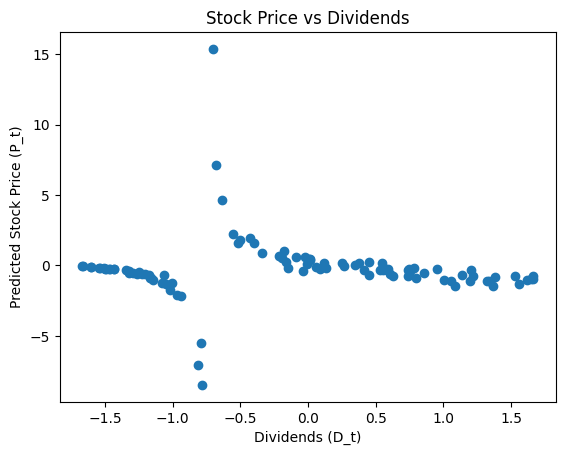

In [22]:
# Plotting P_t against D_t
plt.scatter(X_test[:, 0], P_t_pred)
plt.xlabel('Dividends (D_t)')
plt.ylabel('Predicted Stock Price (P_t)')
plt.title('Stock Price vs Dividends')
plt.show()